In [1]:
import keras

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [5]:
#path = "data/work_data/"
#path = "data/work_data/sample/"
path = "data/"#base_data/"
full_set_mode = "base" in path
model_path = "model/"
batch_size=24

In [6]:
import utils
from utils import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model
from keras.preprocessing import image
import os
from glob import glob
import numpy as np
import annotationHandler
import bboxgenerator

In [9]:
#This is a workaround for now to get bounding-boxes from the filename-structure of the keras-impl.
#we have to reassign the batches afterwards with boundingboxes provided.
train_path = path + 'train'
valid_path = path + 'valid'
size=(224,224)
batches = get_batches(train_path, batch_size=batch_size, shuffle=False, target_size=size)
train_bboxes = annotationHandler.create_bbx("data/annotations", size, batches.filenames, train_path)
if not full_set_mode:
    val_batches = get_batches(valid_path, batch_size=batch_size, shuffle=False, target_size=size)
    val_bboxes = annotationHandler.create_bbx("data/annotations", size, val_batches.filenames, valid_path)

Found 3062 images belonging to 8 classes.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.
Found 715 images belonging to 8 classes.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.


In [10]:
size=(224,224)
batches = bboxgenerator.DirectoryIterator(directory=train_path, batch_size=batch_size, target_size=size, shuffle=True, mappable_extras=[train_bboxes])
if not full_set_mode:
    val_batches = bboxgenerator.DirectoryIterator(valid_path, batch_size=batch_size, target_size=size, shuffle=False, mappable_extras=[val_bboxes])

Found 3062 images belonging to 8 classes.
Found 715 images belonging to 8 classes.


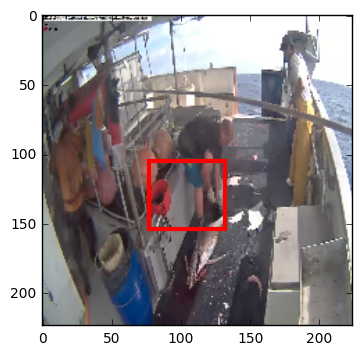

In [18]:
test = next(batches)
utils.show_bb(test, 3)

In [103]:
BASEMODELS = []

In [104]:
from keras.applications import ResNet50
resnet = ResNet50(include_top=False,input_shape=(3,224,224))
BASEMODELS.append(resnet)

In [105]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size,include_top=False)
#base_model = vgg.model
BASEMODELS.append(vgg.model)
#model.summary()

/usr/local/lib64/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_13 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


vgg16_bn_conv.h5


In [124]:
def add_single_custom_layer(base_model):
    for layer in base_model.layers:
        layer.trainable=False
    
    x = base_model.output
    x = BatchNormalization(axis=1)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x)
    newmodel = Model(input=base_model.input, output=[x_bb, x_class])
    return newmodel

def add_advanced_custom_layer(base_model): 
    for layer in base_model.layers:
        layer.trainable=False
    
    p = 0.2
    x = base_model.output
    #x = MaxPooling2D()(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(p/4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x)
    newmodel = Model(input=base_model.input, output=[x_bb, x_class])
    return newmodel

TOP_LAYERS = [add_custom_layer, add_single_custom_layer]

In [136]:
MODELS = [lay(base) for base in BASEMODELS for lay in TOP_LAYERS]
MODELNAMES = ['m1','m2','m3','m4']

In [140]:
def train(model,modelname, epochs, full_run):
    
    print('running ' + modelname)
    model.compile(Adam(lr=0.001), 
              loss=['mse', 'categorical_crossentropy'], 
              metrics=['accuracy'],
              loss_weights=[.001, 1.])
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                  patience=2, min_lr=0.00001)
    
    ckpt = keras.callbacks.ModelCheckpoint( 'model/' + modelname + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', 
                                           verbose=0, save_best_only=False, save_weights_only=False, 
                                           mode='auto', period=1)

    
    if not full_run:
        model.fit_generator(batches, samples_per_epoch=64, nb_epoch=epochs, 
                            validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                           callbacks = [reduce_lr,ckpt])
    else:
        model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=epochs,
                           callbacks = [reduce_lr])
        
    del model.model

In [142]:
for model,modelname in zip(MODELS,MODELNAMES):
    train(model,modelname, 10, full_run=full_set_mode)

runningm1
Epoch 1/1
48/64 [=====================>........] - ETA: 0s - loss: 7.2745 - bb_loss: 4727.8594 - class_loss: 2.5466 - bb_acc: 0.3750 - class_acc: 0.1667

/usr/local/lib64/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


72/64 [=================================] - 17s - loss: 7.9568 - bb_loss: 5011.5874 - class_loss: 2.9453 - bb_acc: 0.3889 - class_acc: 0.1944 - val_loss: 6.8197 - val_bb_loss: 5057.3208 - val_class_loss: 1.7624 - val_bb_acc: 0.3636 - val_class_acc: 0.4699
runningm2
Epoch 1/1
72/64 [=================================] - 17s - loss: 7.0444 - bb_loss: 4797.9207 - class_loss: 2.2465 - bb_acc: 0.2917 - class_acc: 0.3194 - val_loss: 6.7345 - val_bb_loss: 4956.9358 - val_class_loss: 1.7775 - val_bb_acc: 0.3748 - val_class_acc: 0.4643
runningm3


KeyboardInterrupt: 

## Submit

In [144]:
submod = keras.models.load_model('m1_weights.00-6.82.hdf5')

In [145]:
1

1

In [147]:
test_batches = get_batches("data/base_data/test", batch_size=batch_size, shuffle=False, target_size=size, class_mode=None)

Found 1000 images belonging to 1 classes.


In [ ]:
preds = submod.predict_generator(test_batches, test_batches.nb_sample)
#Simen se ovenfor på rute 14. Lagret noen flere endringer. 

In [ ]:
filenames = test_batches.filenames
ids = np.array([f[8:] for f in filenames])
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)
subm = do_clip(preds[1],0.82)


In [ ]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', ids)
submission.head()

In [ ]:
submission.to_csv(path + 'results/fishy5.csv', index=False)